In [1]:
# Import Dependencies
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
%matplotlib inline

# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, you will build a SKLearn linear regression model to predict Yen futures ("settle") returns with *lagged* Yen futures returns. 

In [2]:
# Read Futures Contract on the Yen-Dollar Exchange Rate Data
yen_futures = pd.read_csv(Path("Data/yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True)

# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]

# Show Data
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


# Data Preparation

### Returns

In [3]:
# Create Return Column Off Percent Change of Settle Price
yen_futures['Return'] = yen_futures["Settle"].pct_change() * 100

# Drop NaN Values
yen_futures = yen_futures.dropna()

# Show Tail
yen_futures.tail()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Return
Date,,,,,,,,,
2019-10-09,9381.0,9391.5,9330.5,9343.5,38.5,9338.0,99153.0,145470.0,-0.410601
2019-10-10,9343.5,9380.5,9293.5,9301.0,34.5,9303.5,159397.0,144474.0,-0.369458
2019-10-11,9308.5,9309.0,9240.0,9267.0,52.5,9251.0,158810.0,147471.0,-0.564304
2019-10-14,9259.0,9292.0,9250.5,9261.0,14.0,9265.0,69457.0,153902.0,0.151335
2019-10-15,9264.5,9280.0,9216.5,9220.0,43.5,9221.5,108342.0,151564.0,-0.469509


### Lagged Returns 

In [4]:
# Create Lagged Return
yen_futures['Lagged_Return'] = yen_futures["Return"].shift()

# Drop NaN Values
yen_futures = yen_futures.dropna()

# Show Tail
yen_futures.tail()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Return,Lagged_Return
Date,,,,,,,,,,
2019-10-09,9381.0,9391.5,9330.5,9343.5,38.5,9338.0,99153.0,145470.0,-0.410601,0.170931
2019-10-10,9343.5,9380.5,9293.5,9301.0,34.5,9303.5,159397.0,144474.0,-0.369458,-0.410601
2019-10-11,9308.5,9309.0,9240.0,9267.0,52.5,9251.0,158810.0,147471.0,-0.564304,-0.369458
2019-10-14,9259.0,9292.0,9250.5,9261.0,14.0,9265.0,69457.0,153902.0,0.151335,-0.564304
2019-10-15,9264.5,9280.0,9216.5,9220.0,43.5,9221.5,108342.0,151564.0,-0.469509,0.151335


### Train Test Split

In [5]:
# Create Train Split
train = yen_futures[:'2018']

# Create Test Split
test = yen_futures['2018':]

# Create X Train
X_train = train["Lagged_Return"]

# Create X Test
X_test = test["Lagged_Return"]

# Create Y Train
y_train = train["Return"]

# Create Y Test
y_test = test["Return"]

In [6]:
# Create Function to Test Train/Test Splits
def trainTest(X_train, X_test, y_train, y_test):
    
    # Create Linear Regression Model
    model = LinearRegression()

    # Fit SKLearn Linear Regression
    model.fit(X_train.to_frame(), y_train)
    
    # Make Prediction of Y Values
    predictions = model.predict(X_test.to_frame())
    
    # Assemble Actual Y Data into DataFrame
    Results = y_test.to_frame()
    
    # Add Predicted Y Data into DataFrame
    Results["Predicted Return"] = predictions
    
    # Plot the first 20 predictions vs the true values
    first_20_plot = Results[:20].plot(subplots=True);
    
    # Construct Dataframe using Y Training Data
    in_sample_results = y_train.to_frame()

    # Add Column of In Sample Predictions
    in_sample_results["In-sample Predictions"] = model.predict(X_train.to_frame())

    # Calculate In Sample Mean Squared Error
    in_sample_mse = mean_squared_error(in_sample_results["Return"],in_sample_results["In-sample Predictions"])
    
    # Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
    in_sample_rmse = np.sqrt(in_sample_mse)
    
    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(Results["Return"], Results["Predicted Return"])

    # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    
    # Return Plot & RMSE
    return first_20_plot, in_sample_rmse, rmse

In-sample Root Mean Squared Error (RMSE): 0.5658708047560468
Out-of-Sample Root Mean Squared Error (RMSE): 0.41521675083603804


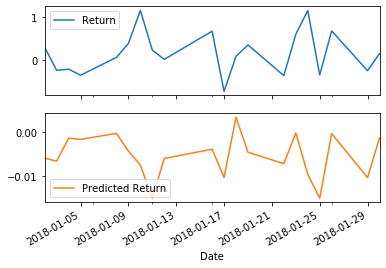

In [7]:
# Assign Return Values to Variables
first_20_plot, in_rmse, out_rmse = trainTest(X_train, X_test, y_train, y_test)

# Print Analysis
print(f"""In-sample Root Mean Squared Error (RMSE): {in_rmse}
Out-of-Sample Root Mean Squared Error (RMSE): {out_rmse}""")

In [8]:
# Split Data Based Off SKLearn Model Selection's 'train_test_split'
X_train, X_test, y_train, y_test = train_test_split(yen_futures['Lagged_Return'], yen_futures["Return"], random_state=42)

In-sample Root Mean Squared Error (RMSE): 0.5462311848384084
Out-of-Sample Root Mean Squared Error (RMSE): 0.5434718223692928


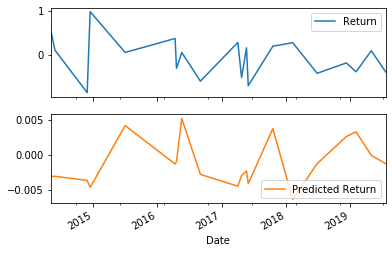

In [9]:
# Assign Return Values to Variables
modified_first_20_plot, modified_in_rmse, modified_out_rmse = trainTest(X_train, X_test, y_train, y_test)

# Print Analysis
print(f"""In-sample Root Mean Squared Error (RMSE): {modified_in_rmse}
Out-of-Sample Root Mean Squared Error (RMSE): {modified_out_rmse}""")

In [10]:
# Find Difference Between Out Sample Results
out_sample_difference = modified_out_rmse - out_rmse

# Condition if Difference Favors SKLearn Model Selection's 'train_test_split'
if out_sample_difference > 0:
    
    # Print Analysis
    print("SKLearn Model Selection's 'train_test_split' did a better job splitting our dataset than our manual selection.")
    
# Condition if Difference is Zero
elif out_sample_difference == 0:
    
    # Print Analysis
    print("There is no difference between SKLearn Model Selection's 'train_test_split' and our manual selection.")
    
# Condition if Difference Favors Manual Selection
elif out_sample_difference < 0:
    
    # Print Analysis
    print("SKLearn Model Selection's 'train_test_split' did a worst job splitting our dataset than our manual selection.")

SKLearn Model Selection's 'train_test_split' did a better job splitting our dataset than our manual selection.


# Conclusions

In [11]:
# Specify Output Location 
output_file_location = "../Conclusions/conclusions.txt"

# Write Observable Trends to Text File
with open(output_file_location, "a",) as txtfile:
    txtfile.write(f"""   
4. Does this model perform better or worse on out-of-sample data compared to in-sample data?

This model performed significantly worse on the out-of-sample data when using our manual selection for train/test splits. 
However, using SKLearn Model Selection's 'train_test_split', the model does similarily as well on the out-of-sample data
as it did on the in-sample data.

""")